<a href="https://colab.research.google.com/github/sachin032/Tensorflow/blob/master/Exercise-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Dependencies**

In [0]:
try:
    !pip install -q tf-nightly-gpu-2.0-preview fuzzywuzzy metaphone whoosh jellyfish
except Exception:
    pass

In [127]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU Device not Found')
print('Found gpu at: {} '.format(device_name))

Found gpu at: /device:GPU:0 


# **Enviornment information**

In [128]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits 

In [129]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2535530982271856866, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10980504635039496663
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5907667903917559005
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6245373427664763382
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

# **Data collection**

In [131]:
from google.colab import files
data =  files.upload()

Saving BigData.csv to BigData (3).csv


# **Import Dependencies**

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import io
import pathlib
from tensorflow.keras.preprocessing.text import Tokenizer,hashing_trick,one_hot,text_to_word_sequence

from jellyfish import jaro_winkler, levenshtein_distance, soundex
from whoosh.analysis import StandardAnalyzer
from metaphone import doublemetaphone
from fuzzywuzzy import fuzz

# **Custom Functions**

In [0]:
def tokenize(text):
    analyzer = StandardAnalyzer()
    return [t.text for t in analyzer(text)]


def overlap(A, B):
    try:
        if A is None or B is None or len(A) == 0 or len(B) == 0:
            return 0.0
        setA = tokenize(A)
        setB = tokenize(B)
        num_intersection = setA.intersection(setB)
        min_len = len(setA)
        if (min_len > len(setB)):
            min_len = len(setB)
        return float(intersection) / min_len
    except:
        pass


def jaccard(A, B):
    if A is None or B is None or len(A) == 0 or len(B) == 0:
        return 0.0
    setA = tokenize(A)
    setB = tokenize(B)
    num_intersection = setA.intersection(setB)
    return float(intersection) / (len(setA) + len(setB) - intersection)


def overlap_levenshtein(A, B):
    try:
        if A is None or B is None or len(A) == 0 or len(B) == 0:
            return 0.0
        setA = set(tokenize(A))
        setB = set(tokenize(B))
        num_intersection = len(setA.intersection(setB))
        max_dist = 0
        for wordA in setA:
            max_dist = 0
            for wordB in setB:
                if wordA not in list(
                        setA.intersection(setB)) and wordB not in list(
                            setA.intersection(setB)):
                    dist = levenshtein_distance_metric(wordA, wordB)
                    if dist > max_dist and dist > 0.75:
                        max_dist = dist
            num_intersection = num_intersection + max_dist
        min_len = len(setA)
        if (min_len > len(setB)):
            min_len = len(setB)
        if min_len == 0:
            return 0.0
        return float(num_intersection) / min_len
    except:
        pass


def jaccard_levenshtein(A, B):
    if A is None or B is None or len(A) == 0 or len(B) == 0:
        return 0.0
    setA = tokenize(A)
    setB = tokenize(B)
    num_intersection = len(setA.intersection(setB))
    for wordA in setA:
        max_dist = 0
        for wordB in setB:
            if wordB not in setA.intersection(setB):
                dist = levenshtein_distance_metric(wordA, wordB)
                if dist > max_dist and max_dist > 0.75:
                    max_dist = dist
            num_intersection = num_intersection + max_dist
    return float(num_intersection) / (len(setA) + len(setB) - num_intersection)


def levenshtein_distance_metric(A, B):
    try:
        if A is None or B is None or len(A) == 0 or len(B) == 0:
            return 0.0
        max_len = len(A)
        if max_len < len(B):
            max_len = len(B)
        return 1 - float(levenshtein_distance(A, B)) / max_len
    except:
        pass


def jaro_winkler_metric(A, B):
    if A is None or B is None or len(A) == 0 or len(B) == 0:
        return 0.0

    return float(jaro_winkler(A.lower(), B.lower()))


def exact_metric(A, B):
    if A is None or B is None:
        return 0.0
    if A == B:
        return 0.25
    else:
        return 0.0


def overlap_levenshtein(A, B):
    try:
        if A is None or B is None or len(A) == 0 or len(B) == 0:
            return 0.0
        setA = set(tokenize(A))
        setB = set(tokenize(B))
        num_intersection = len(setA.intersection(setB))
        intersected_word = list(setA.intersection(setB))
        max_dist = 0
        for wordA in setA:
            max_dist = 0
            for wordB in setB:
                if wordA not in intersected_word and wordB not in intersected_word:
                    dist = levenshtein_distance_metric(wordA, wordB)
                    if dist > max_dist and dist > 0.75:
                        max_dist = dist
            num_intersection = num_intersection + max_dist
        min_len = len(setA)
        if (min_len > len(setB)):
            min_len = len(setB)
        if min_len == 0:
            return 0.0
        return float(num_intersection) / min_len
    except Exception:
        pass


def soundex_metric(A, B):
    try:
        if A is None or B is None or A is "" or B is "" or len(A) == 0 or len(
                B) == 0:
            return 0.0

        setA = tokenize(A)
        setB = tokenize(B)
        soundexA = set()
        soundexB = set()
        for wordA in setA:
            soundexA.add(soundex(wordA))

        for wordB in setB:
            soundexB.add(soundex(wordB))

        intersection = 0
        for wordA in soundexA:
            if wordA in soundexB:
                intersection = intersection + 1

        min_len = len(soundexA)
        if min_len > len(soundexB):
            min_len = len(soundexB)
        if min_len == 0.0:
            return 0.0

        return float(intersection) / (min_len)
    except:
        pass


def swapped_attribute(fir, sec, pair_of_header, func, header_index):
    combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
    metric_values = list()
    for each_combination in combinations:
        metric_values.append(
            func(fir[header_index[pair_of_header[each_combination[0]]]],
                 sec[header_index[pair_of_header[each_combination[1]]]]))
    swp_1 = metric_values[0] + metric_values[3]
    swp_2 = metric_values[1] + metric_values[2]
    if swp_1 > swp_2:
        return metric_values[0], metric_values[3]
    else:
        return metric_values[1], metric_values[2]




# **Feature Engineering**

In [0]:
def applyAlgorithms(dataframe, algorithms, column_list):
    counter = 0
    column_length = len(column_list)
    for key, values_list in algorithms.items():
        values_list.sort()
        if key == LEVENSHTEIN:
            for value in values_list:
                column_name_list = [
                    column_name for column_name in column_list
                    if value in column_name
                ]
                col_name = value + "_" + str(column_length + counter)
                df[col_name] = df.apply(
                    lambda row: levenshtein_distance_metric(
                        row['%s' % column_name_list[0]], row[
                            '%s' % column_name_list[1]]),
                    axis=1)
                # dataframe = dataframe.withColumn("feature_"+str(column_length+counter), apply_levenshtein(column_name_list[0], column_name_list[1]))
                counter = counter + 1

        elif key == SOUNDEX:
            for value in values_list:
                column_name_list = [
                    column_name for column_name in column_list
                    if value in column_name
                ]
                col_name = value + "_" + str(column_length + counter)
                df[col_name] = df.apply(
                    lambda row: soundex_metric(row['%s' % column_name_list[
                        0]], row['%s' % column_name_list[1]]),
                    axis=1)
                # dataframe = dataframe.withColumn("feature_"+str(column_length+counter), apply_soundex(column_name_list[0], column_name_list[1]))
                counter = counter + 1

        elif key == OVERLAP:
            for value in values_list:
                column_name_list = [
                    column_name for column_name in column_list
                    if value in column_name
                ]
                col_name = value + "_" + str(column_length + counter)
                df[col_name] = df.apply(
                    lambda row: overlap(row['%s' % column_name_list[0]], row[
                        '%s' % column_name_list[1]]),
                    axis=1)
                # dataframe = dataframe.withColumn("feature_"+str(column_length+counter), apply_overlap(column_name_list[0], column_name_list[1]))
                counter = counter + 1

        elif key == OVERLAPLEVENSHTEIN:
            for value in values_list:
                column_name_list = [
                    column_name for column_name in column_list
                    if value in column_name
                ]
                col_name = value + "_" + str(column_length + counter)
                df[col_name] = df.apply(lambda row: overlap_levenshtein(
                    row['%s' % column_name_list[0]], row['%s' %
                                                         column_name_list[1]]),
                                        axis=1)
                # dataframe = dataframe.withColumn("feature_"+str(column_length+counter), apply_overlap_levenshtein(column_name_list[0], column_name_list[1]))
                counter = counter + 1

        elif key == JACCARD:
            for value in values_list:
                column_name_list = [
                    column_name for column_name in column_list
                    if value in column_name
                ]
                col_name = value + "_" + str(column_length + counter)
                df[col_name] = df.apply(
                    lambda row: jaccard(row['%s' % column_name_list[0]], row[
                        '%s' % column_name_list[1]]),
                    axis=1)
                # dataframe = dataframe.withColumn("feature_"+str(column_length+counter), apply_jaccard(column_name_list[0], column_name_list[1]))
                counter = counter + 1

        if key == JACCARDLEVENSHTEIN:
            for value in values_list:
                column_name_list = [
                    column_name for column_name in column_list
                    if value in column_name
                ]
                col_name = value + "_" + str(column_length + counter)
                df[col_name] = df.apply(lambda row: jaccard_levenshtein(
                    row['%s' % column_name_list[0]], row['%s' %
                                                         column_name_list[1]]),
                                        axis=1)
                # dataframe = dataframe.withColumn("feature_"+str(column_length+counter), apply_jaccard_levenshtein(column_name_list[0], column_name_list[1]))
                counter = counter + 1

    return dataframe, counter

In [0]:
df = bb[0]
train_df = df[[
    'system_address_14', 'system_alternatename_15', 'system_businessname_16',
    'system_phonenumber_17', 'system_universalbusinessnumber_18',
    'system_alternatename_19', 'system_businessname_20', 'LABEL'
]]
target = train_df.pop("LABEL")
dataset = tf.data.Dataset.from_tensor_slices((train_df.values, target.values))
bb = applyAlgorithms(dataframe=df, algorithms=algos, column_list=cols)

# **Taxonomy Declaration**

In [0]:
ACCOUNT_NAME = 'accountName'
ACCOUNT_KEY = 'accountKey'
CONTAINER_NAME = 'containerName'
ANALYTICS_EXTERNAL = 'analytics-external'
BLOB_END_SUFFIX = ".blob.core.windows.net"
BLOB_PREFIX = "fs.azure.account.key."
ANALYTICS_INTERNAL = 'analytics-internal'
LEVENSHTEIN = 'levenshtein'
SOUNDEX = 'soundex'
OVERLAP = 'overlap'
OVERLAPLEVENSHTEIN = 'overlapLevenshtein'
JACCARD = 'jaccard'
JACCARDLEVENSHTEIN = 'jaccardLevenshtein'

In [0]:
np.set_printoptions(precision=4)
df = pd.read_csv(io.StringIO(data['BigData.csv'].decode('utf-8')))
df['system_universalbusinessnumber_11'] = df[
    'system_universalbusinessnumber_11'].astype(str)
df['system_universalbusinessnumber_12'] = df[
    'system_universalbusinessnumber_11'].astype(str)
# df = df.drop([
#     'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18',
#     'feature_19', 'feature_20', 'feature_21'
# ],
#              axis=1)

In [0]:
algos = {
    'jaro_winkler': [],
    'exact_match': [],
    'overlapLevenshtein': [
        'system_businessname', 'system_address', 'system_alternatename',
        'system_phonenumber', 'system_universalbusinessnumber'
    ],
    'soundex': ['system_businessname', 'system_alternatename']
}

cols = [
    'id', 'system_businessname_1', 'system_businessname_2',
    'system_alternatename_3', 'system_alternatename_4', 'system_address_5',
    'system_address_6', 'system_phonenumber_7', 'system_phonenumber_8',
    'system_dateofinception_9', 'system_dateofinception_10',
    'system_universalbusinessnumber_11', 'system_universalbusinessnumber_12',
    'LABEL'
]

# **Model Building**

In [0]:
import tensorflow as tf
from keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorboardcolab import TensorBoardColabCallback

In [0]:
DATASET_SIZE = len(df)

In [0]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

In [0]:
full_dataset = dataset.shuffle(len(df)).batch(1)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99):
            print(
                "\n\n\nAchieved accuracy above 99% so halting any further training!\nas it might cause Overfitting\n\n"
            )
            self.model.stop_training = True

callback = myCallback()

In [0]:
from tensorflow.keras.optimizers import RMSprop
tf.keras.backend.set_floatx('float64')

#Model 6H8N 
def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=RMSprop(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  verbose=1,
                  callbacks = [callback]
                  ) 
    
    return model

In [146]:
model = get_compiled_model()
model_history = model.fit(x=train_dataset,
                    validation_data=val_dataset ,
                    epochs=20)

Epoch 1/20
25776/25776 [==============================] - 157s 6ms/step - loss: 0.4389 - accuracy: 0.7749 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
25776/25776 [==============================] - 103s 4ms/step - loss: 0.4589 - accuracy: 0.7714 - val_loss: 0.6416 - val_accuracy: 0.7753
Epoch 3/20
25776/25776 [==============================] - 101s 4ms/step - loss: 0.4789 - accuracy: 0.7647 - val_loss: 0.9715 - val_accuracy: 0.7737
Epoch 4/20
25776/25776 [==============================] - 99s 4ms/step - loss: 0.4809 - accuracy: 0.7689 - val_loss: 0.4434 - val_accuracy: 0.7592
Epoch 5/20
25776/25776 [==============================] - 102s 4ms/step - loss: 0.4750 - accuracy: 0.7688 - val_loss: 0.4306 - val_accuracy: 0.7663
Epoch 6/20
25776/25776 [==============================] - 101s 4ms/step - loss: 0.4588 - accuracy: 0.7750 - val_loss: 0.4404 - val_accuracy: 0.7858
Epoch 7/20
25776/25776 [==============================] - 101s 4ms/step - loss: 0.4718 - accuracy: 0.7772

In [0]:
import matplotlib.pyplot as plt
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epochs = range(len(acc))

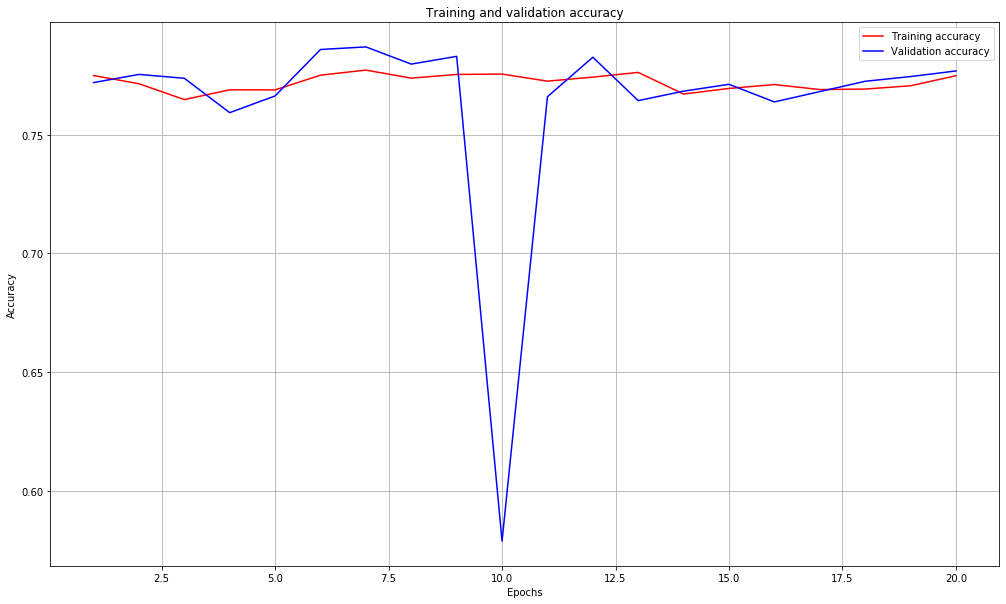

In [148]:
plt.figure(figsize=(17,10))
plt.plot(range(1,21), acc, 'r', label='Training accuracy')
plt.plot(range(1,21), val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.grid()
plt.show()

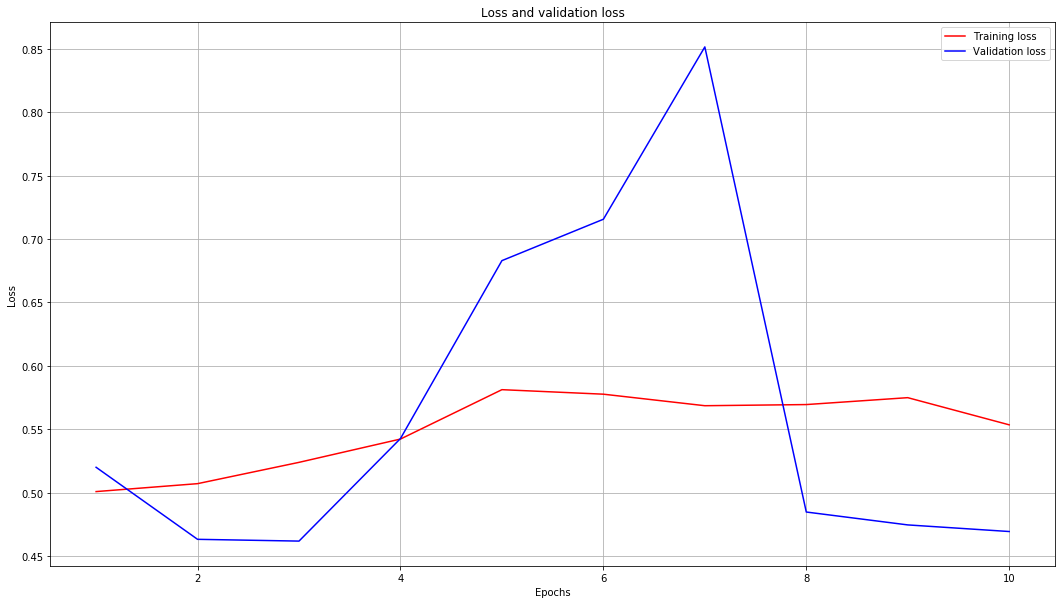

In [150]:

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(18,10))
plt.plot(range(1,11), loss, 'r', label='Training loss')
plt.plot(range(1,11), val_loss, 'b', label='Validation loss')
plt.title('Loss and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid()
plt.show()

In [0]:
#Model 6H8N with dropouts
def get_dropout_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation='relu', ),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=RMSprop(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  verbose=1,
                  callbacks = [callback]
                  ) 
    
    return model

In [152]:
droput_model = get_dropout_compiled_model()

droput_history = droput_model.fit(x=train_dataset,
                    validation_data=val_dataset,
                    epochs=10)

Epoch 1/10
25776/25776 [==============================] - 165s 6ms/step - loss: 0.5405 - accuracy: 0.7566 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
25776/25776 [==============================] - 109s 4ms/step - loss: 0.5806 - accuracy: 0.7580 - val_loss: 0.4649 - val_accuracy: 0.7531
Epoch 3/10
25776/25776 [==============================] - 108s 4ms/step - loss: 0.5647 - accuracy: 0.7632 - val_loss: 0.4861 - val_accuracy: 0.7359
Epoch 4/10
25776/25776 [==============================] - 109s 4ms/step - loss: 0.5838 - accuracy: 0.7615 - val_loss: 0.4876 - val_accuracy: 0.7699
Epoch 5/10
25776/25776 [==============================] - 110s 4ms/step - loss: 0.5455 - accuracy: 0.7587 - val_loss: 0.5921 - val_accuracy: 0.7549
Epoch 6/10
25776/25776 [==============================] - 109s 4ms/step - loss: 0.6317 - accuracy: 0.7574 - val_loss: 0.5922 - val_accuracy: 0.7589
Epoch 7/10
25776/25776 [==============================] - 109s 4ms/step - loss: 0.5893 - accuracy: 0.760

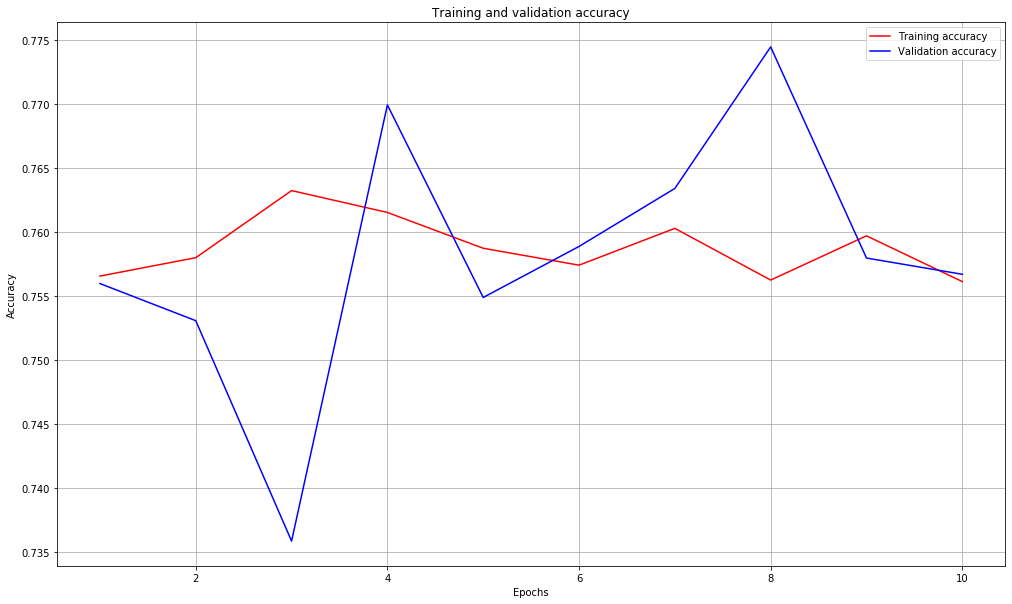

In [153]:
acc = droput_history.history['accuracy']
val_acc = droput_history.history['val_accuracy']
epochs = range(len(acc))
plt.figure(figsize=(17,10))
plt.plot(range(1,11), acc, 'r', label='Training accuracy')
plt.plot(range(1,11), val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.grid()
plt.show()

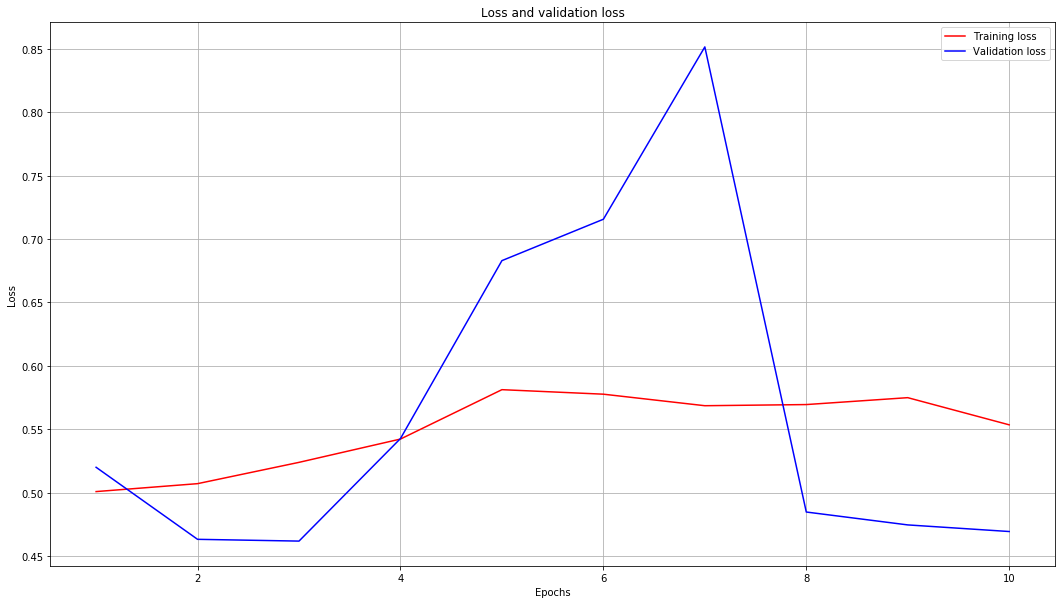

In [155]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(18,10))
plt.plot(range(1,11), loss, 'r', label='Training loss')
plt.plot(range(1,11), val_loss, 'b', label='Validation loss')
plt.title('Loss and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid()
plt.show()

In [154]:
print(droput_model.layers)
print(droput_model.summary())
print(droput_model.outputs)
print(droput_model.inputs)

[<tensorflow.python.keras.layers.core.Dense object at 0x7fc6182d2978>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc617250b70>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fc6172446a0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc617244588>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fc6172443c8>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc617244390>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fc6172441d0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc6172440b8>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fc617244780>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc617244cf8>, <tensorflow.python.keras.layers.core.Dense object at 0x7fc617244e48>]
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             multiple                  64        


# **TensorFlow Dataset API for GPU and TPU processing**

<br> <br> <br> 
**Load Data frame and Make Tensor**

In [0]:
data_slices = tf.data.Dataset.from_tensor_slices(dict(df))
for feature_batch in data_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

**Load CSV data and create a tensor**

In [0]:
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=5, # Artificially small to make examples easier to show.
      label_name="LABEL",
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

raw_train_data = get_dataset("/content/BigData.csv")

In [0]:
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

show_batch(raw_train_data)

<br><br><br><br><br>

In [0]:
processed_df, counter = applyAlgorithms(dataframe=df,algorithms=algos,column_list=cols)

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

# !pip install tensorboardcolab
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip



# LOG_DIR = './log'
# get_ipython().system_raw('tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))
# get_ipython().system_raw('./ngrok http 6006 &')

# ! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"